# フードバンクにおける食品分配問題
深層強化学習の適用

DQN (Deep Q-Network)

ニューラルネットワークにはPyTorchを使用

In [388]:
# パッケージのimport
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import copy
import datetime
import os
%matplotlib inline

In [389]:
# namedtupleを生成
from collections import namedtuple

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

### 状態定義

In [390]:
# 状態定義
from enum import IntEnum

# 在庫の残り
class StockRemaining(IntEnum):
    FULL = 0
    MANY = 1
    FEW = 2
    NONE = 3

# 在庫の変動
class StockChange(IntEnum):
    NONE = 0
    SLIGHTLY = 1
    SOMEWHAT = 2
    GREATLY = 3

# エージェントの充足度
class Satisfaction(IntEnum):
    HARDLY = 0
    SOMEWHAT = 1
    COMLETELY = 2
    OVERLY = 3

# 終端状態の区別用
class Progress(IntEnum):
    ONGOING = 0
    DONE = 1

### ハイパーパラメータ

In [391]:
# 学習用パラメータ
NUM_EPISODES = 1001
MAX_STEPS = 30
GREEDY_CYCLE = 50

GAMMA = 0.98

INITIAL_EPSILON = 1.0
MINIMUM_EPSILON = 1.0
EPSILON_DELTA = (INITIAL_EPSILON - MINIMUM_EPSILON) / (NUM_EPISODES * 0.95)

ALPHA = 0.0001
# INITIAL_ALPHA = 0.1
# MINIMUM_ALPHA = 0.0001
# ALPHA_DELTA = (INITIAL_ALPHA - MINIMUM_ALPHA) / (NUM_EPISODES * 0.95)

HIDDEN_SIZE = 32

BATCH_SIZE = 32
CAPACITY = 100



# 環境設定
AGENTS_COUNT = 1
FOODS = [5, 5, 5]
NUM_FOODS = len(FOODS)
REQUESTS = [
    [1, 3, 5],
]


### 経験再生

In [392]:
# 経験を保存するメモリクラスを定義

from collections import deque

class ReplayMemory:
    """
    Experience Replay(経験再生)を実装するクラス
    学習データを一定数メモリに保存し、ランダムにサンプリングすることで
    時系列の相関をなくすことができる
    """

    def __init__(self, capacity):
        """メモリを初期化"""
        # 状態遷移を保持するバッファ
        self.memory = deque([], maxlen=capacity)
        # deque: double-ended queue （両端キュー）
        # 両サイドからデータを取り出したり追加できる
        # リストに比べて先頭・末尾の操作がO(1)の計算量で済む
        # 最大要素数のcapacityを超えると古い要素から削除される

    def push(self, state, action, state_next, reward):
        '''transition = (state, action, state_next, reward)をメモリに保存する'''
        
        tensor_state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        tensor_state_next = torch.tensor(state_next, dtype=torch.float).unsqueeze(0)
        tensor_action = torch.tensor([action], dtype=torch.long).unsqueeze(0)
        tensor_reward = torch.tensor([reward], dtype=torch.long)

        # namedtupleのTransitionを使用し、値とフィールド名をペアにして保存します
        t = Transition(tensor_state, tensor_action, tensor_state_next, tensor_reward)
        self.memory.append(t)


    def sample(self, batch_size):
        '''batch_size分だけ、ランダムに保存内容を取り出す'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''関数lenに対して、現在の変数memoryの長さを返す'''
        return len(self.memory)


### Deep Q-Network

In [393]:
# エージェントが持つ脳

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F


class Brain:
    def __init__(self, num_states, num_actions, f):
        self.f = f
        self.num_actions = num_actions

        # 経験を記憶するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)

        # ニューラルネットワークを構築
        self.model = nn.Sequential()
        self.model.add_module('fc1', nn.Linear(num_states, HIDDEN_SIZE))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('fc2', nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE))
        self.model.add_module('relu2', nn.ReLU())
        self.model.add_module('fc3', nn.Linear(HIDDEN_SIZE, num_actions))

        print(self.model)  # ネットワークの形を出力

        # 最適化手法の設定
        self.optimizer = optim.Adam(self.model.parameters(), lr=ALPHA)

    

    def replay(self, greedy):
        '''Experience Replayでネットワークの結合パラメータをミニバッチ学習'''

        # メモリサイズがミニバッチより小さい間は何もしない
        if len(self.memory) < BATCH_SIZE:
            return

        # メモリからミニバッチ分のデータを取り出す
        transitions = self.memory.sample(BATCH_SIZE)

        # 各変数をミニバッチに対応する形に変形
        batch = Transition(*zip(*transitions))

        # 各変数の要素をミニバッチに対応する形に変形し、ネットワークで扱えるようVariableにする
        # print(f"batch.state: {batch.state}")
        # print(f"batch.action: {batch.action}")

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # 終端状態でない次状態のマスク（終端でない所がTrueになる）
        # non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)))
        # 終端状態でない次状態を抜き出す
        # non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        # 終端状態でない次状態のマスク（終端でない所がTrueになる）
        non_final_mask = torch.tensor(tuple(map(lambda s: s.numpy()[0][-1] != Progress.DONE, batch.next_state)))
        # 終端状態でない次状態を抜き出す
        non_final_next_states = torch.cat([s for s in batch.next_state if s.numpy()[0][-1] != Progress.DONE])

        # print(test_states)
        # if len(test_states) != BATCH_SIZE:
        #     print(len(test_states))

        # ネットワークを推論モードに切り替える
        self.model.eval()

        # print(f"state_batch: {state_batch}")
        # print(f"出力: {self.model(state_batch)}")
        # print(f"action_batch: {action_batch}")
        # print(f"reward_batch: {reward_batch}")

        # 現在のQ値（NNの出力）
        current_q_values = torch.gather(self.model(state_batch), 1, action_batch)
        # print(f" current_q_values: {current_q_values.max()}")

        
        # 次状態のQ値の最大値
        next_max_q_values = torch.zeros(BATCH_SIZE) # すべて0にしておく
        # 終端状態でないインデックスに、次状態の最大Q値を挿入
        next_max_q_values[non_final_mask] = self.model(non_final_next_states).max(1)[0].detach()

        # print(f"次状態の出力: {self.model(state_next_batch)}")
        # print(f"次状態の最大Q値: {next_max_q_values}")

        # 教師データとなるQ値の目標値
        # （報酬 + 割引率 * 次状態の最大Q値）
        target_q_values = (reward_batch + GAMMA * next_max_q_values).unsqueeze(1)

        # next_states = torch.cat(batch.next_state).numpy()
        # test_index = np.where(next_states[-1] != Progress.DONE)
        # target_final = target_q_values[test_index]
        # if target_final.max() > 0:
        #     print(target_final.max())

        # max_value = target_q_values.max()
        # if max_value > 0:
        #     print(max_value)

        # if (max_value > 100):
        #     print(f"state_batch: {state_batch}")
        #     print(f"action_batch: {action_batch}")
        #     print(f"reward_batch: {reward_batch}")
        #     print(f"current_q_values: {current_q_values}")
        #     print(f"次状態の最大Q値: {next_max_q_values}")
        #     print(f"教師データ: {target_q_values}")

        # ネットワークを訓練モードに切り替える
        self.model.train()

        # if greedy:
        #     diff = target_q_values - current_q_values
        #     print(f"TD誤差: {diff}", file=self.f)

        # 損失関数を計算する（smooth_l1_lossはHuberloss）
        criterion = nn.SmoothL1Loss()
        loss = criterion(current_q_values, target_q_values)

        # if greedy:
        #     print(f"TD: {target_q_values - current_q_values}")
            # print(f"current_q_values: {current_q_values}")
            # print(f"target_q_values: {target_q_values}")


        # 結合パラメータを更新する
        self.optimizer.zero_grad()  # 勾配をリセット

        
        loss.backward()  # バックプロパゲーションを計算

        nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()  # 結合パラメータを更新

    def decide_action(self, state, options, greedy, epsilon):
        '''現在の状態に応じて、行動を決定する'''
        # ε-greedy法で徐々に最適行動のみを採用する
        # epsilon = 0.5 * (1 / (episode + 1))
        greedy_print = greedy


        if greedy is False:
            # ε-greedyで行動を決定する
            if np.random.rand() >= epsilon:
                greedy = True

        if greedy:
            self.model.eval()  # ネットワークを推論モードに切り替える

            tensor_state = torch.tensor(state, dtype=torch.float)

            # print(state)
            # print(tensor_state)
        
            with torch.no_grad():
                q = self.model(tensor_state).numpy()
                # print(f"Q値: {q}")
                options_q = q[options]
                max_arg = np.argmax(options_q)
                action = options[max_arg]
                # print(f"action: {action}")
                if greedy_print:
                    print(f"Q値: {q} 選択した行動: {action}", file=f)
                
            # ネットワークの出力の最大値のindexを取り出す

        else:
            action = random.choice(options)
            # print(f"ランダムな行動: {action}")

        return action

### エージェント

In [394]:
# Agentクラス

class Agent:
    def __init__(self, name, request, num_states, num_actions,  f):
        self.name = name
        self.REQUEST = request
        self.brain = Brain(num_states, num_actions, f)
        self.f = f

    def reset(self, env_stock, greedy):
        self.current_requests = self.REQUEST.copy()
        self.stock = np.zeros(NUM_FOODS, dtype=np.int64)

        self.food_done = False
        self.learning_done = False
        self.old_env_stock = env_stock.copy()



    def learn(self, greedy):
        # if state == state_next:
        #     if greedy:
        #         print(f"{self.name}: 状態が変化していません", file=self.f)
        # else:
        #     self.brain.replay()
        self.brain.replay(greedy)
        


    # 行動（どの食品を取得するか）を決定
    def get_action(self, state, env_stock, greedy, epsilon):
        # 行動の候補
        action_options = []

        # 本部に在庫がある食品を候補に入れる
        for food in range(len(env_stock)):
            if env_stock[food] != 0:
                action_options.append(food)


        # 「何もしない」という選択肢も候補に加える
        action_options.append(NUM_FOODS)


        # 行動を決定
        action = self.brain.decide_action(state, action_options, greedy, epsilon)

        return action


    def memorize(self, state, action, state_next, reward, greedy):
        '''memoryオブジェクトに、state, action, state_next, rewardの内容を保存する'''
        if state == state_next:
            if greedy:
                print(f"{self.name}: 状態が変化していません", file=self.f)
        else:
            if greedy:
                print("--- メモリに保存 ---", file=self.f)
                print("現在の状態: ", file=self.f)
                self.print_state(state)
                print(f"とった行動: {action}", file=self.f)
                print("次の状態: ", file=self.f)
                self.print_state(state_next)
                print(f"獲得した報酬: {reward}", file=self.f)
                print("-----------------", file=self.f)
            self.brain.memory.push(state, action, state_next, reward)


    def observe_state(self, env_stock, episode_terminal):
        remainings = []
        changes = []
        satisfactions = []
        progress = []

        granularity = len(StockRemaining) - 2
        for amount, original in zip(env_stock, FOODS):
            section = round(original / granularity)
            if amount == 0:
                remainings.append(StockRemaining.NONE)
            elif amount < section:
                remainings.append(StockRemaining.FEW)
            elif amount < original:
                remainings.append(StockRemaining.MANY)
            else:
                remainings.append(StockRemaining.FULL)

        difference = self.old_env_stock - env_stock
        for diff in difference:
            if diff == 0:
                changes.append(StockChange.NONE)
            elif diff == 1:
                changes.append(StockChange.SLIGHTLY)
            elif diff == 2:
                changes.append(StockChange.SOMEWHAT)
            else:
                changes.append(StockChange.GREATLY)

        satisfaction_rates = self.stock / self.REQUEST
        for rate in satisfaction_rates:
            if rate < 0.5:
                satisfactions.append(Satisfaction.HARDLY)
            elif rate < 1:
                satisfactions.append(Satisfaction.SOMEWHAT)
            elif rate == 1:
                satisfactions.append(Satisfaction.COMLETELY)
            else:
                satisfactions.append(Satisfaction.OVERLY)

        if episode_terminal:
            progress.append(Progress.DONE)
        else:
            progress.append(Progress.ONGOING)

        state = tuple(remainings + changes + satisfactions + progress)

        # state = tuple(remainings + satisfactions + progress)

        self.old_env_stock = env_stock.copy()

        return state


    def grab_food(self, food):
        # 手元の在庫が1つ増える
        self.stock[food] += 1
        # 要求リストから1つ減らす
        if (self.current_requests[food] != 0):
            self.current_requests[food] -= 1

        self.check_satisfied()

    def check_satisfied(self):
        # print(f"要求: {self.current_requests}")
        if np.all(self.current_requests == 0):
            # 要求がすべて満たされたことを記録
            self.food_done = True
            # print(f"{self.name} 要求がすべて満たされました")

        # TODO: 食品ごとに調べる（要求があっても食品の在庫がない場合）

    def get_violation(self):
        diffs = self.REQUEST - self.stock
        diff_rates = diffs / self.REQUEST * 10
        abs_diffs = np.absolute(diff_rates)
        violation = np.sum(abs_diffs)

        # if (abs(violation) > 100):
        #     print(f"violation: {violation}")

        self.violation = violation
        return violation


    def print_state(self, state):
        num = NUM_FOODS
        print(f"{self.name} State: ", end="", file=self.f)

        print("Remaining[ ", end="", file=self.f)
        for i in range(num):
            print(f"{state[i].name} ", end="", file=self.f)
        print("], Change[ ", end="", file=self.f)
        for i in range(num, num * 2):
            print(f"{state[i].name} ", end="", file=self.f)
        print("], Satisfaction[ ", end="", file=self.f)
        for i in range(num * 2, num * 3):
            print(f"{state[i].name} ", end="", file=self.f)

        print(f"] Progress[{state[num * 3].name}]", file=self.f)


### 環境

In [395]:
class Environment:

    def __init__(self, f):
        self.f = f
        self.agents = self.init_agents()

    def init_agents(self):
        state_size = pow(len(StockRemaining), NUM_FOODS) * pow(len(StockChange),
                                                                  NUM_FOODS) * pow(len(Satisfaction), NUM_FOODS) * len(Progress)
        num_states = NUM_FOODS * 3 + 1
        num_actions = NUM_FOODS + 1

        print("========= 各エージェントのもつ状態行動空間 =========", file=self.f)
        print(f"状態数: {state_size:,}", file=self.f)
        print(f"行動数: {num_actions}", file=self.f)
        print(f"状態 × 行動の組み合わせ: {(state_size * num_actions):,}", file=self.f)
        print("\n\n", file=self.f)

        agents: List[Agent] = []
        for i in range(AGENTS_COUNT):
            name = f"Agent{i + 1}"
            agent = Agent(
                name, np.array(REQUESTS[i]), num_states, num_actions, self.f)
            agents.append(agent)
        return agents

    def reset(self, greedy):
        self.stock = np.array(FOODS, dtype=np.int64)
        states = None

        for agent in self.agents:
            agent.reset(self.stock, greedy)

        return states

    def get_actions(self, states):
        actions = []
        # すべてのエージェントに対して
        for agent, state in zip(self.agents, states):
            # 行動を決定
            action = agent.get_action(state)
            actions.append(action)
            if action == NUM_FOODS:
                # print(f"{agent.name} 行動: 何もしない")
                pass
            else:
                # print(f"{agent.name} 行動: 食品{action}を１つ取る")
                pass
        return actions

    def check_food_run_out(self):
        # 全ての在庫が0になったかチェック
        return np.all(self.stock == 0)

    def check_agents_food_done(self):
        # 全てのエージェントが終了条件を満たしているかチェック
        all_done = True
        for agent in self.agents:
            if not agent.food_done:
                all_done = False
                break
        # 全エージェントの取れる行動がなくなったか
        return all_done

    def check_agents_learning_done(self):
        all_done = True
        for agent in self.agents:
            if not agent.learning_done:
                all_done = False
                break
        return all_done

    # def learn(self, states, actions, rewards, states_next, alpha):
    #     for agent, state, action, reward, state_next in zip(self.agents, states, actions, rewards, states_next):
    #         agent.learn(state, action, reward, state_next, alpha)

    def get_reward(self, target_agent: Agent, terminal, greedy):
        if terminal:
            # - |制約違反度の平均からの偏差|
            # violations = []
            # for agent in self.agents:
            #     v = agent.get_violation()
            #     violations.append(v)
            # mean = np.mean(violations)
            # abs_deviation = np.absolute(mean - target_agent.get_violation())
            # reward = - abs_deviation

            # - (制約違反度 + 制約違反度の標準偏差)
            violations = []
            for agent in self.agents:
                v = agent.get_violation()
                # print(f"violation: {v}")
                violations.append(v)
            std = np.std(violations)
            # print(f"std: {std}")
            
            reward = - (target_agent.get_violation() + std)
            # print(f"reward: {reward}")

            # - (制約違反度の平均+標準偏差)　統一
            # violations = []
            # for agent in self.agents:
            #     v = agent.get_violation()
            #     violations.append(v)
            # mean = np.mean(violations)
            # std = np.std(violations)
            # reward = - (mean + std)

            if greedy:
                print(
                    f"{target_agent.name}: 報酬{reward:.3f}  要求{target_agent.REQUEST} 在庫{target_agent.stock}", file=self.f)

        else:
            # reward = -1
            reward = 0
       
        return reward

    def print_env_state(self):
        print("Env State: [", end="", file=self.f)
        for status in self.env_state:
            print(f"{status.name} ", end="", file=self.f)

        print("]", file=self.f)

### メイン

Linear(in_features=10, out_features=32, bias=True)
ReLU()
Linear(in_features=32, out_features=32, bias=True)
ReLU()
Linear(in_features=32, out_features=4, bias=True)
Sequential(
  (fc1): Linear(in_features=10, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)
-------------- Episode:0 (greedy) --------------
reward: -22.0


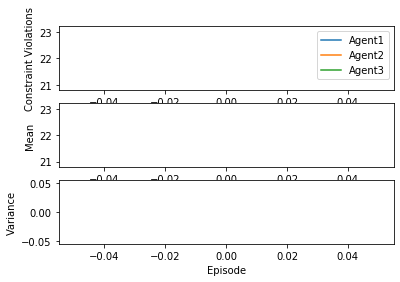

KeyboardInterrupt: 

In [396]:


np.set_printoptions(precision=5, floatmode='maxprec_equal')
np.set_printoptions(suppress=True)

DIR_PATH = "D:\\Lighthouse\\Documents\\Reinforcement Learning\\Food Distribution\\results"

start_time = datetime.datetime.now()
file_name_time = "{0:%Y-%m-%d_%H%M%S}".format(start_time)

log_name = f"log_{file_name_time}.txt"
log_path = os.path.join(DIR_PATH, "logs", log_name)
f = open(log_path, mode="w", encoding="UTF-8")

print("フードバンク食品分配 Deep Q-Network\n", file=f)

print("開始時刻: {0:%Y/%m/%d %H:%M:%S}\n".format(start_time), file=f)

print("====================== 環境設定 ======================", file=f)
print(f"食品の種類: {NUM_FOODS}", file=f)
print(f"本部の在庫: {FOODS}", file=f)
print(f"エージェント数: {AGENTS_COUNT}", file=f)
print(f"エージェントの要求リスト: {REQUESTS}", file=f)
print("\n\n", file=f)

print("==================== 学習パラメーター ====================", file=f)
print(f"エピソード数: {NUM_EPISODES:,}", file=f)
print(f"最大ステップ数: {MAX_STEPS:,}\n", file=f)
print(f"割引率: {GAMMA}\n", file=f)
print(f"学習率: {ALPHA}", file=f)
print(f"εの初期値: {INITIAL_EPSILON}", file=f)
print(f"εの最終値: {MINIMUM_EPSILON}", file=f)
print(f"1エピソードごとのεの減少値: {EPSILON_DELTA:.7f}", file=f)
print("\n\n", file=f)

print("====================== 報酬設定 ======================", file=f)
print("- (制約違反度 + 制約違反度の標準偏差)", file=f)
# print("- |制約違反度の平均からの偏差|", file=f)
# print("- (制約違反度の平均 + 標準偏差) 統一", file=f)
print("\n\n", file=f)

env = Environment(f)

result_episodes = []
results_agents_y = [[], [], []]

result_ave = []
result_dev = []

epsilon = INITIAL_EPSILON

fig = plt.figure()

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.set_xlabel("Episode")
ax2.set_xlabel("Episode")
ax3.set_xlabel("Episode")

ax1.set_ylabel("Constraint Violations")
ax2.set_ylabel("Mean")
ax3.set_ylabel("Variance")

line1, = ax1.plot([], [], label="Agent1")
line2, = ax1.plot([], [], label="Agent2")
line3, = ax1.plot([], [], label="Agent3")

line_ave, = ax2.plot([], [])
line_dev, = ax3.plot([], [])

ax1.legend()

lines = [line1, line2, line3]

# 各エピソード
for episode in range(NUM_EPISODES):

    if episode % GREEDY_CYCLE == 0:
        greedy = True
        print(
            f"-------------- Episode:{episode} (greedy) --------------")
        print(
            f"\n\n-------------- Episode:{episode} (greedy) ----------------------------------------------------------------------", file=f)
    else:
        greedy = False
        # print(f"-------------- Episode:{episode} --------------")
    states = [[], [], []]
    actions = [[], [], []]
    rewards = [0, 0, 0]

    old_states = env.reset(greedy)
    old_actions = []

    learning_complete = False
    step = 0

    if greedy:
        # print(f"学習率: {alpha:.5f}", file=f)
        print(f"ε: {epsilon:.5f}", file=f)

    # 各ステップ
    while True:
        if greedy:
            print(f"\n------- Step:{step} -------", file=f)

        # 各エージェント
        for index, agent in enumerate(env.agents):

            # 終了条件確認
            food_done = env.check_food_run_out()
            all_agents_done = env.check_agents_food_done()
            exceed_max_step = step == MAX_STEPS - 1

            episode_terminal = food_done or all_agents_done or exceed_max_step

            if greedy:
                print(f"\n本部の在庫: {env.stock}", file=f)
                print(f"{agent.name}の在庫:{agent.stock}", file=f)
                diff = agent.old_env_stock - env.stock
                print(f"{agent.name}視点の本部在庫の変化:{diff}", file=f)
                if episode_terminal:
                    print("*** 終了条件を満たしています ***", file=f)

            # 状態を観測
            state = agent.observe_state(env.stock, episode_terminal)
            states[index] = state

            if greedy:
                agent.print_state(state)

            # 行動を決定
            if not episode_terminal:
                action = agent.get_action(
                    state, env.stock, greedy, epsilon)
                actions[index] = action

                if greedy:
                    if action == NUM_FOODS:
                        action_string = "何もしない"
                    else:
                        action_string = f"食品{action}"

                    print(
                        f"{agent.name} 選択した行動: {action_string}", file=f)

                # 行動をとる
                if action != NUM_FOODS:
                    # エージェントが食品を1つとる
                    agent.grab_food(action)
                    # 本部の在庫が1つ減る
                    env.stock[action] -= 1

            reward = env.get_reward(agent, episode_terminal, greedy)

            if old_states is not None:
                agent.memorize(old_states[index], old_actions[index], state, reward, greedy)
                agent.learn(greedy)

            if episode_terminal:
                if greedy:
                    print(f"{agent.name} 学習終了\n", file=f)

                rewards[index] = reward
                agent.learning_done = True
                learning_complete = env.check_agents_learning_done()
                if learning_complete:
                    break

        if exceed_max_step and greedy:
            print("最大ステップ数を超えました", file=f)

        if learning_complete:
            break

        old_states = copy.deepcopy(states)
        old_actions = copy.deepcopy(actions)

        step += 1


    if epsilon > MINIMUM_EPSILON:
        epsilon = epsilon - EPSILON_DELTA

    if greedy:
        print(
            f"************ Episode{episode}の結果 ************", file=f)
        print(f"要したステップ数: {step}", file=f)
        print(f"食品の残り個数: {np.sum(env.stock)}", file=f)
        violations = []
        for agent, reward in zip(env.agents, rewards):
            print(
                f"{agent.name}の在庫: {agent.stock}  制約違反度: {agent.violation:.3f}  報酬: {reward:.3f}", file=f)
            print(f"reward: {reward}")
            violations.append(agent.violation)

        mean = np.average(violations)
        var = np.std(violations)

        print(f"制約違反度の平均: {mean:.3f}  分散: {var:.3f}", file=f)
        # print(f"現在のエピソード: {episode}")
        # result_reward_x.append(episode)
        # result_reward_y.append(rewards[0])
        # result_optimal_reward_x.append(episode)
        # result_optimal_reward_y.append(optimal_reward)
        # lines1.set_data(result_reward_x, result_reward_y)
        result_episodes.append(episode)
        result_ave.append(mean)
        result_dev.append(var)

        for i, agent, line, result in zip(range(AGENTS_COUNT), env.agents, lines, results_agents_y):
            # result.append(rewards[i])
            result.append(violations[i])
            line.set_data(result_episodes, result)

        line_ave.set_data(result_episodes, result_ave)
        line_dev.set_data(result_episodes, result_dev)

        # lines1.set_data(result_agents_x, result_agent1_y)
        # lines2.set_data(result_agents_x, result_agent2_y)
        # lines3.set_data(result_agents_x, result_agent3_y)

        ax1.relim()
        ax1.autoscale_view()

        ax2.relim()
        ax2.autoscale_view()

        ax3.relim()
        ax3.autoscale_view()

        # lines1.set_data(result_satisfaction_x, result_satisfaction_y)

        # lines2.set_data(result_optimal_reward_x, result_optimal_reward_y)
        plt.pause(0.001)

# print("\n---- 最適解 ----")
# for agent, loss, stock, request in zip(env.agents, optimal_loss_values, optimal_agent_stock, REQUESTS):
#     diff = stock - request
#     print(f"{agent.name}: 損失{loss:.1f} 要求との差{diff} 在庫{stock}")
# print(f"報酬: {optimal_reward:.4f}")
# print(f"発見したエピソード: {optimal_episode}")

end_time = datetime.datetime.now()
print("\n終了時刻: {0:%Y/%m/%d %H:%M:%S}".format(end_time), file=f)

figure_name = f"figure_{file_name_time}.png"
figure_path = os.path.join(DIR_PATH, "figures", figure_name)
plt.savefig(figure_path)

# csv_name = f"data_{file_name_time}.csv"
# csv_path = os.path.join(DIR_PATH, "data", csv_name)
# with open(csv_path, "w", newline='', encoding="UTF-8") as csv_f:
#     writer = csv.writer(csv_f)
#     writer.writerow(["Episode", "Distance"])
#     writer.writerows(self.result)

print("\n\n終了")

plt.show()

f.close()